# Import relevant libraries/modules etc

In [ ]:
from tqdm import tqdm

In [1]:
import numpy as np
import xarray as xr
import rasterio
%matplotlib inline
from matplotlib.pyplot import *
from glob import glob
import os
import datetime
import pandas as pd
from rasterio_to_xarray import rasterio_to_xarray

# Create an array with MAIAC data

- create a function which reads in the files, determines the no data values, and creates a third dim 'time'
- create a list with all of the files to be put in the 3d array
- run the function on every element of list (map)

x = rasterio_to_xarray(r'D:\Annies_Dissertation\MAIAC_Test\Projected\2014\MAIACAAOT.h00v01.20140011255.hdf_proj.tif')

In [2]:
def maiac_file_to_da(filename):
    da = rasterio_to_xarray(filename)
    
    da.values[da.values == -28672] = np.nan
    da.values[da.values == 0] = np.nan
    
    time_str = os.path.basename(filename)[17:-13]
    time_obj = datetime.datetime.strptime(time_str, '%Y%j%H%M')
    da.coords['time'] = time_obj
    
    return da

In [3]:
files = glob(r'D:\Annies_Dissertation\MAIAC_Test\Projected\2014\*_proj.tif')

maiac_file_to_da(files[0])

In [4]:
list_of_das = map(maiac_file_to_da, files)

In [5]:
res = xr.concat(list_of_das, 'time')

- view the dataset
- view the different 3D timestamps

In [6]:
res

<xarray.DataArray (time: 23, y: 1162, x: 1240)>
array([[[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ..., 
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ..., 
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ..., 
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  

In [7]:
res.time

<xarray.DataArray 'time' (time: 23)>
array(['2014-01-01T12:55:00.000000000', '2014-01-01T14:30:00.000000000',
       '2014-01-02T12:00:00.000000000', '2014-01-02T13:35:00.000000000',
       '2014-01-03T12:40:00.000000000', '2014-01-03T14:20:00.000000000',
       '2014-01-04T11:45:00.000000000', '2014-01-04T13:25:00.000000000',
       '2014-01-04T15:05:00.000000000', '2014-01-05T12:30:00.000000000',
       '2014-01-05T14:10:00.000000000', '2014-01-06T11:35:00.000000000',
       '2014-01-06T13:10:00.000000000', '2014-01-06T14:50:00.000000000',
       '2014-01-07T12:15:00.000000000', '2014-01-07T13:55:00.000000000',
       '2014-01-08T13:00:00.000000000', '2014-01-08T14:40:00.000000000',
       '2014-01-09T12:05:00.000000000', '2014-01-09T13:45:00.000000000',
       '2014-01-10T12:45:00.000000000', '2014-01-10T14:25:00.000000000',
       '2014-01-11T11:50:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2014-01-01T12:55:00 2014-01-01T14:30:00 ...

# Group data
- merge multiple images per day using the maximum AOT estimates
- the third dimension is now called date (rather than time)

In [8]:
r = res.groupby('time.date').max(dim='time')

In [9]:
r.date

<xarray.DataArray 'date' (date: 11)>
array([datetime.date(2014, 1, 1), datetime.date(2014, 1, 2),
       datetime.date(2014, 1, 3), datetime.date(2014, 1, 4),
       datetime.date(2014, 1, 5), datetime.date(2014, 1, 6),
       datetime.date(2014, 1, 7), datetime.date(2014, 1, 8),
       datetime.date(2014, 1, 9), datetime.date(2014, 1, 10),
       datetime.date(2014, 1, 11)], dtype=object)
Coordinates:
  * date     (date) object 2014-01-01 2014-01-02 2014-01-03 2014-01-04 ...

# Analysis
## overall average of every pixel

In [ ]:
overall_mean = r.mean(dim='date')

In [ ]:
overall_mean

In [ ]:
figure(figsize=(20, 12))
overall_mean.plot(robust=True)

#### *Save overall_mean out

### Take date bits and convert to nanoseconds

In [ ]:
r['date'] = pd.to_datetime(r['date'])

In [ ]:
r['date']

## Time series over one pixel
- get the information (time series) over one pixel
- validate against AERONET Chibolton site

In [ ]:
Chilbolton = res.isel(x=1103, y=1027).dropna('time').to_pandas()

In [ ]:
Chilbolton

In [ ]:
Chil_AOT = Chilbolton/1000

In [ ]:
Chil_AOT

In [ ]:
Chil_AOT.to_csv(r'D:\Annies_Dissertation\Methodology\Validation\Comparision\MAIAC\Chilbolton_AOT_MAIAC.csv')

## Averages
### Monthly

In [ ]:
monthly = r.groupby('date.month').max(dim='date')

In [ ]:
monthly.coords

In [ ]:
figure(figsize=(20, 12))
monthly.plot(col='month', robust=True)

### Seasonal

In [ ]:
seasonal = r.groupby('date.season').max(dim'date')

In [ ]:
seasonal.coords

In [ ]:
figure(figsize=(20, 12))
season.plot(col='season', robust=True)

### Yearly

In [ ]:
yearly = r.groupby('date.year').max(dim='date')

In [ ]:
yearly.coords

In [ ]:
figure(figsize=(20, 12))
yearly.plot(col='year', robust=True)

# Count of values that aren't missing

In [16]:
observations = r.count(dim='date')

(array([  1.11791600e+06,   0.00000000e+00,   2.16945000e+05,
          0.00000000e+00,   8.35610000e+04,   0.00000000e+00,
          1.94620000e+04,   0.00000000e+00,   2.91600000e+03,
          8.00000000e+01]),
 array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ]),
 <a list of 10 Patch objects>)

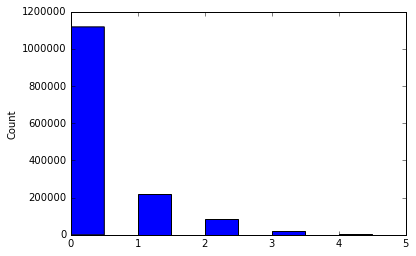

In [17]:
observations.plot.hist()